# Case Study Project - Food Claims Process

## Company Background and customer Question

<p>Vivendo is a fast food chain in Brazil with over 200 outlets. As with many fast food
establishments, customers make claims against the company. For example, they blame
Vivendo for suspected food poisoning.
The legal team, who processes these claims, is currently split across four locations. The new
head of the legal department wants to see **if there are differences in the time it takes to close
claims across the locations.**</p>

<p>The legal team has given you a data set where each row is a claim made against the
company. They would like you to answer the following questions:
<li>How does the number of claims differ across locations?
<li>What is the distribution of time to close claims?
<li>How does the average time to close claims differ by location?</li></p>


## 1. Imports & setup

### 1.1. Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


### 1.2. Viz parameters

In [2]:
sns.set_style('whitegrid')
sns.set_palette("husl",3)
matplotlib.rcParams.update({'font.size': 12})

### 1.3. Load dataset

In [3]:
df = pd.read_csv('datasets/claims.csv')
df.head()

,Claim ID,Time to Close,Claim Amount,Amount Paid,Location,Individuals on Claim,Linked Cases,Cause
0,0000000-00.2010.0.00.0094,2082,"R$50,000.00",34297.47,RECIFE,2,False,NaN
1,0000000-00.2011.0.00.0086,3591,"R$180,000.00",56383.54,SAO LUIS,7,False,NaN
2,0000000-00.2012.0.00.0092,2997,"R$70,000.00",12366.76,SAO LUIS,3,False,vegetables
3,0000000-00.2013.0.00.0096,1143,"R$95,104.00",29217.16,FORTALEZA,4,False,NaN
4,0000000-00.2014.0.00.0097,117,"R$29,000.00",12610.50,FORTALEZA,1,False,meat


## 2. Data preparation

### 2.1. Data validation

TODO : package following code into a function called "describe"

In [4]:
keys = ['df']
values = [df]
for z1, z2 in zip(keys, values):
    shape = z2.shape
    ncol = z2.shape[1]
    dup = z2.duplicated().sum()
    na = z2.isna().sum()
    uq = z2.nunique()
    datalists = dict()
    keys_p = ['duplicates', 'na', 'unique', 'dtype']
    keys_d = ['non-null count', 'mean/mode', 'std', 'min', '25%', '50%', '75%', 'max']
    for k in (keys_p + keys_d):
        datalists[k] = []
    for col in range(ncol):  #loading keys_p values
        datalists['duplicates'].append(z2.iloc[:,col].duplicated().sum())
        datalists['na'].append(z2.isna().sum()[col])
        datalists['unique'].append(z2.nunique()[col])
        datalists['dtype'].append(z2.dtypes[col])
    for k2 in enumerate(keys_d):  # loading keys_d values
        for col in range(ncol):
            if len(z2.iloc[:,col].describe())==8: # describe method outputs 8 values on numeric columns, 4 on others
                datalists[k2[1]].append(round(z2.iloc[:,col].describe()[k2[0]],2))
            else:
                if k2[1]=='non-null count':
                    datalists[k2[1]].append(z2.count()[col])
                elif k2[1]=='mean/mode':
                    datalists[k2[1]].append(z2.iloc[:,col].mode()[0])
                else:
                    datalists[k2[1]].append('NC')
    print(z1, 'dataframe - ', f'shape:{shape}', f'dupl:{dup}')
    display(pd.DataFrame(datalists, index = pd.MultiIndex.from_tuples([c for c in enumerate(z2.columns)], names=['#', 'Column'])))

df dataframe -  shape:(98, 8) dupl:0


,,duplicates,na,unique,dtype,non-null count,mean/mode,std,min,25%,50%,75%,max
#,Column,,,,,,,,,,,,
0,Claim ID,0,0,98,object,98.0,0000000-00.2010.0.00.0094,NC,NC,NC,NC,NC,NC
1,Time to Close,2,0,96,int64,98.0,832.35,686.85,-57.0,340.75,638.5,1138.75,3591.0
2,Claim Amount,24,0,74,object,98.0,"R$40,000.00",NC,NC,NC,NC,NC,NC
3,Amount Paid,0,0,98,float64,98.0,58448.24,87525.87,999.68,15965.64,29451.04,52114.76,558725.77
4,Location,94,0,4,object,98.0,SAO LUIS,NC,NC,NC,NC,NC,NC
5,Individuals on Claim,79,0,19,int64,98.0,4.91,7.29,0.0,1.0,2.0,5.75,41.0
6,Linked Cases,96,0,2,bool,98.0,False,NC,NC,NC,NC,NC,NC
7,Cause,95,78,2,object,20.0,meat,NC,NC,NC,NC,NC,NC


This summary reaveals no missing data except for 'Cause' column where we get an indication on how to proceed.
Higher duplicates levels are observed on 'categorical-like' data (Location, Cause) or booleans (Linked Cases) which is perfectly normal.
'Claim Amount' and 'Individual on Claim' are quantitative data but lots of duplicates can lead us to group clusters.

Column Name |Type|Criteria|Datatype|Cleaning steps|
------------|----|--------|--------|--------------|
Claim ID |Character|the unique identifier of the claim.|quali |no |
Time to Close |Numeric|number of days it took for the claim to be closed.|quanti _continuous_ |no, eventually cast as datetime interval |
Claim Amount |Numeric|initial claim value in the currency of Brazil. For example, “R$50,000.00” should be converted into 50000.|quanti _continuous_ |cast to numeric after text manipulation |
Amount Paid |Numeric|total amount paid after the claim closed in the currency of Brazil.|quanti _continuous_ |no |
Location |Character|location of the claim, one of “RECIFE”, “SAO LUIS”, “FORTALEZA”, or “NATAL”.|quali |convert to categorical (n=4) |
Individuals on Claim |Numeric|number of individuals on this claim.|quanti _discrete_ |no |
Linked Cases |Binary|whether this claim is believed to be linked with other cases, either TRUE or FALSE.|quali _bool_ |no |
Cause |Character|the cause of the food poisoning injuries, one of ‘vegetable’, ‘meat’, or ‘unknown’. Replace any empty rows with ‘unknown’.|quali |replace any empty rows with ‘unknown’, then convert to categorical (n=3) |

### 2.2. Data cleaning

In [5]:
# cleaning text from Claim Amount column
df['Claim Amount'] = df['Claim Amount'].str.replace('[,.$R]','', regex=True)
df['Claim Amount'] = df['Claim Amount'].astype('float')
display(df['Claim Amount'].head())

0     5000000.0
1    18000000.0
2     7000000.0
3     9510400.0
4     2900000.0
Name: Claim Amount, dtype: float64

In [6]:
# cleaning Cause column
#before treatment
display(df[df['Cause'].isna()].head())
display(df['Cause'].value_counts())

,Claim ID,Time to Close,Claim Amount,Amount Paid,Location,Individuals on Claim,Linked Cases,Cause
0,0000000-00.2010.0.00.0094,2082,5000000.0,34297.47,RECIFE,2,False,NaN
1,0000000-00.2011.0.00.0086,3591,18000000.0,56383.54,SAO LUIS,7,False,NaN
3,0000000-00.2013.0.00.0096,1143,9510400.0,29217.16,FORTALEZA,4,False,NaN
5,0000000-00.2014.0.00.0077,578,15000000.0,23214.56,FORTALEZA,6,False,NaN
7,0000000-00.2014.0.00.0043,2354,4087000.0,24161.73,FORTALEZA,1,False,NaN


meat          12
vegetables     8
Name: Cause, dtype: int64

In [7]:
#after treatment
df['Cause'] = df['Cause'].fillna('unknown')
display(df[df['Cause'].isna()].head())
print('number of empty rows: ', df['Cause'].isna().sum())
print('\ncount per category:')
display(df['Cause'].value_counts())
print('\nnew dataframe head:')
display(df.head()) 

,Claim ID,Time to Close,Claim Amount,Amount Paid,Location,Individuals on Claim,Linked Cases,Cause


number of empty rows:  0

count per category:


unknown       78
meat          12
vegetables     8
Name: Cause, dtype: int64


new dataframe head:


,Claim ID,Time to Close,Claim Amount,Amount Paid,Location,Individuals on Claim,Linked Cases,Cause
0,0000000-00.2010.0.00.0094,2082,5000000.0,34297.47,RECIFE,2,False,unknown
1,0000000-00.2011.0.00.0086,3591,18000000.0,56383.54,SAO LUIS,7,False,unknown
2,0000000-00.2012.0.00.0092,2997,7000000.0,12366.76,SAO LUIS,3,False,vegetables
3,0000000-00.2013.0.00.0096,1143,9510400.0,29217.16,FORTALEZA,4,False,unknown
4,0000000-00.2014.0.00.0097,117,2900000.0,12610.50,FORTALEZA,1,False,meat


In [8]:
#cleaning inconsistent data
df['Time to Close'].nsmallest(3)

58   -57
83    29
87    30
Name: Time to Close, dtype: int64

In [9]:
df.iloc[58,:]

Claim ID                0000000-00.2019.0.00.0079
Time to Close                                 -57
Claim Amount                             367200.0
Amount Paid                                999.68
Location                                 SAO LUIS
Individuals on Claim                            0
Linked Cases                                False
Cause                                     unknown
Name: 58, dtype: object

Index 58 shows a negative number for 'Time to Close' previously identified in summary stats preview.
We need to solve this typo by either :
<li>dropping the entire line
<li>or interpolating a value
<li>or setting this specific value to NaN</li>

in order not to loose some other data but considering the uncertainty of 'Time to Close' values (large std vs mean), we choose third option.

In [10]:
df['Time to Close'] = df['Time to Close'].replace([-57], np.nan)
df['Time to Close'].nsmallest(5)

83    29.0
87    30.0
78    60.0
62    65.0
94    86.0
Name: Time to Close, dtype: float64

Let's see how our dataset looks like now.<br>
TODO : insert call to function "describe"

In [11]:
df[df['Individuals on Claim']==0]

,Claim ID,Time to Close,Claim Amount,Amount Paid,Location,Individuals on Claim,Linked Cases,Cause
14,0000000-00.2016.0.00.0083,1823.0,1678900.0,5227.91,SAO LUIS,0,False,unknown
38,0000000-00.2018.0.00.0003,925.0,384100.0,1324.24,RECIFE,0,False,unknown
41,0000000-00.2018.0.00.0040,997.0,840100.0,5394.85,NATAL,0,False,unknown
53,0000000-00.2019.0.00.0001,659.0,1042800.0,1722.04,RECIFE,0,False,unknown
57,0000000-00.2019.0.00.0078,495.0,669100.0,4154.22,FORTALEZA,0,False,unknown
58,0000000-00.2019.0.00.0079,NaN,367200.0,999.68,SAO LUIS,0,False,unknown
84,0000000-00.2020.0.00.0064,272.0,355500.0,1013.36,RECIFE,0,False,unknown


In [12]:
keys = ['df']
values = [df]
for z1, z2 in zip(keys, values):
    shape = z2.shape
    ncol = z2.shape[1]
    dup = z2.duplicated().sum()
    na = z2.isna().sum()
    uq = z2.nunique()
    datalists = dict()
    keys_p = ['duplicates', 'na', 'unique', 'dtype']
    keys_d = ['non-null count', 'mean/mode', 'std', 'min', '25%', '50%', '75%', 'max']
    for k in (keys_p + keys_d):
        datalists[k] = []
    for col in range(ncol):  #loading keys_p values
        datalists['duplicates'].append(z2.iloc[:,col].duplicated().sum())
        datalists['na'].append(z2.isna().sum()[col])
        datalists['unique'].append(z2.nunique()[col])
        datalists['dtype'].append(z2.dtypes[col])
    for k2 in enumerate(keys_d):  # loading keys_d values
        for col in range(ncol):
            if len(z2.iloc[:,col].describe())==8: # describe method outputs 8 values on numeric columns, 4 on others
                datalists[k2[1]].append(round(z2.iloc[:,col].describe()[k2[0]],2))
            else:
                if k2[1]=='non-null count':
                    datalists[k2[1]].append(z2.count()[col])
                elif k2[1]=='mean/mode':
                    datalists[k2[1]].append(z2.iloc[:,col].mode()[0])
                else:
                    datalists[k2[1]].append('NC')
    print(z1, 'dataframe - ', f'shape:{shape}', f'dupl:{dup}')
    display(pd.DataFrame(datalists, index = pd.MultiIndex.from_tuples([c for c in enumerate(z2.columns)], names=['#', 'Column'])))

df dataframe -  shape:(98, 8) dupl:0


,,duplicates,na,unique,dtype,non-null count,mean/mode,std,min,25%,50%,75%,max
#,Column,,,,,,,,,,,,
0,Claim ID,0,0,98,object,98.0,0000000-00.2010.0.00.0094,NC,NC,NC,NC,NC,NC
1,Time to Close,2,1,95,float64,97.0,841.52,684.36,29.0,349.0,639.0,1143.0,3591.0
2,Claim Amount,24,0,74,float64,98.0,12295203.06,16643338.9,355500.0,4000000.0,5845450.0,13657325.0,93654000.0
3,Amount Paid,0,0,98,float64,98.0,58448.24,87525.87,999.68,15965.64,29451.04,52114.76,558725.77
4,Location,94,0,4,object,98.0,SAO LUIS,NC,NC,NC,NC,NC,NC
5,Individuals on Claim,79,0,19,int64,98.0,4.91,7.29,0.0,1.0,2.0,5.75,41.0
6,Linked Cases,96,0,2,bool,98.0,False,NC,NC,NC,NC,NC,NC
7,Cause,95,0,3,object,98.0,unknown,NC,NC,NC,NC,NC,NC


Seems data is cleaner now with only 1 missing value in column #1.

## 3. Exploration & visualization

### 3.1. Preliminary EDA

Overview of correlations :

In [13]:
round(df.corr(),3)

,Time to Close,Claim Amount,Amount Paid,Individuals on Claim,Linked Cases
Time to Close,1.000,-0.133,-0.185,-0.137,-0.123
Claim Amount,-0.133,1.000,0.870,0.999,0.871
Amount Paid,-0.185,0.870,1.000,0.869,0.802
Individuals on Claim,-0.137,0.999,0.869,1.000,0.871
Linked Cases,-0.123,0.871,0.802,0.871,1.000


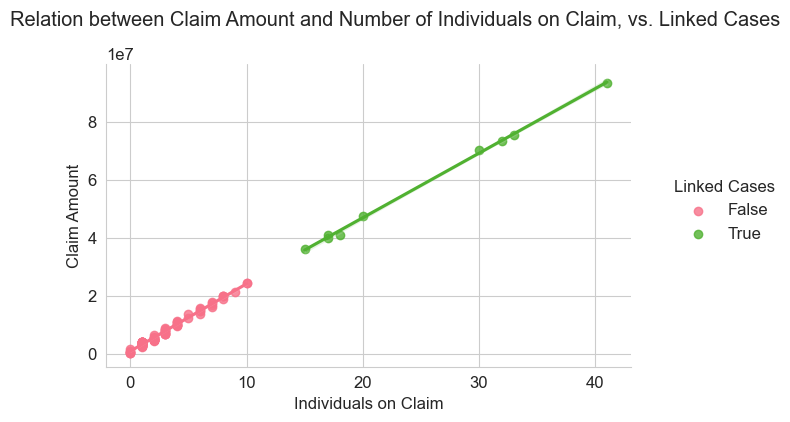

In [32]:
g = sns.lmplot(data=df, x='Individuals on Claim', y='Claim Amount', height=4, aspect=1.5, hue='Linked Cases')
g.fig.suptitle('Relation between Claim Amount and Number of Individuals on Claim, vs. Linked Cases', y=1.05)
plt.show()

There's a clear linear and positive correlation between Claim Amount and Number of Individuals on Claim.
Linked Cases are observable starting from 15 people on Claim.
Let's now study those two features distributions.

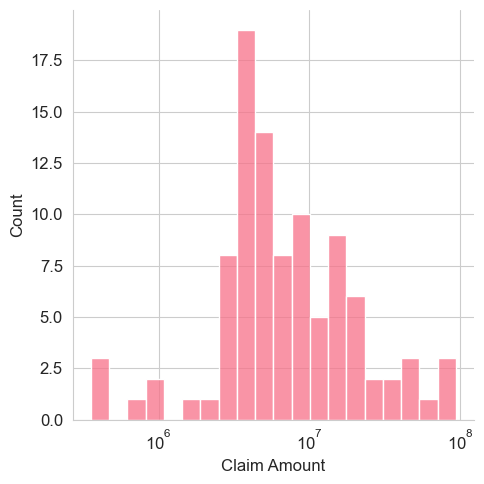

In [15]:
g = sns.displot(data=df, x='Claim Amount', log_scale=True, bins=20)

Using a log scale will help better identify clusters.<br>
A little fine-tuning let us conclude that Claim amounts could eventually be clustered in 3 groups as per below analysis.

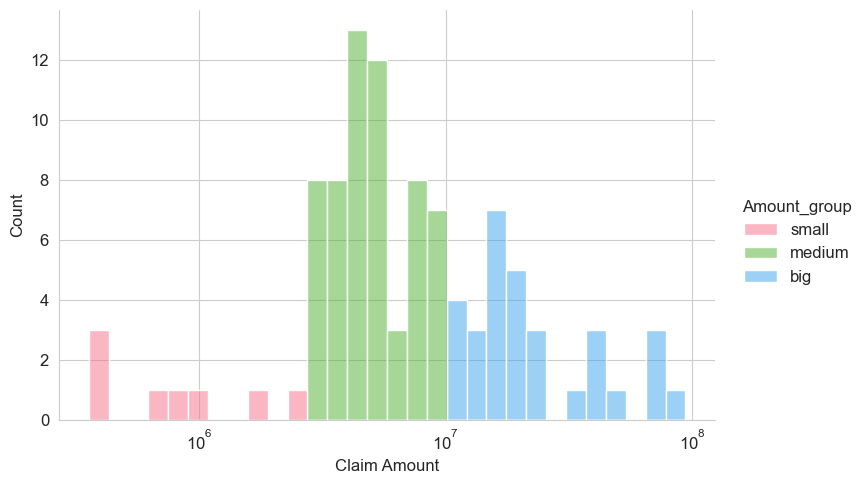

In [16]:
ranges = [0, 2500000, 10000000, np.inf]
amount_group_names = ['small', 'medium', 'big']
df['Amount_group'] = pd.cut(df['Claim Amount'], bins=ranges, labels=amount_group_names)
g = sns.displot(data=df, x='Claim Amount', bins=30, height=5, aspect=1.5, hue='Amount_group', log_scale=True)

Distribution of Nb Individuals on Claim :

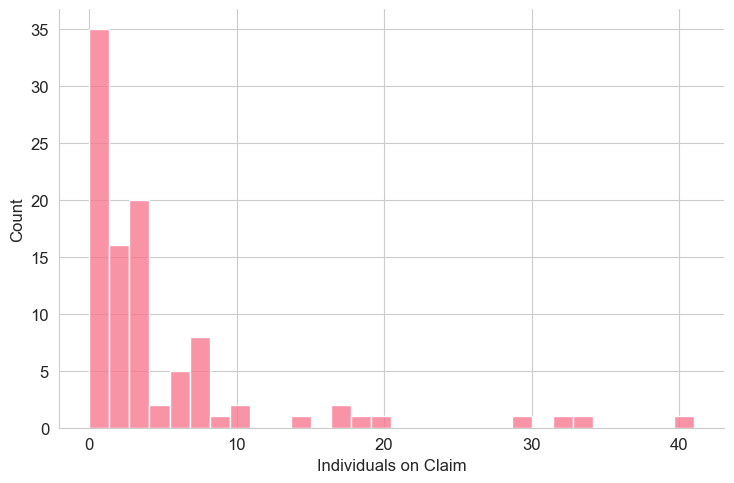

In [17]:
g = sns.displot(data=df, x='Individuals on Claim', bins=30, height=5, aspect=1.5)

Number of individuals on Claim could be clustered in 3 groups :
<li>0-2 : very little
<li>2-20 : little to medium
<li>20+ : large</li>

In [18]:
ranges = [0, 2, 20, np.inf]
indiv_group_names = ['0-2', '2-20', '20+']
df['Individuals_group'] = pd.cut(df['Individuals on Claim'], bins=ranges, labels=indiv_group_names)
df[['Individuals_group', 'Individuals on Claim']]

,Individuals_group,Individuals on Claim
0,0-2,2
1,2-20,7
2,2-20,3
3,2-20,4
4,0-2,1
...,...,...
93,2-20,3
94,0-2,2
95,0-2,2
96,2-20,20


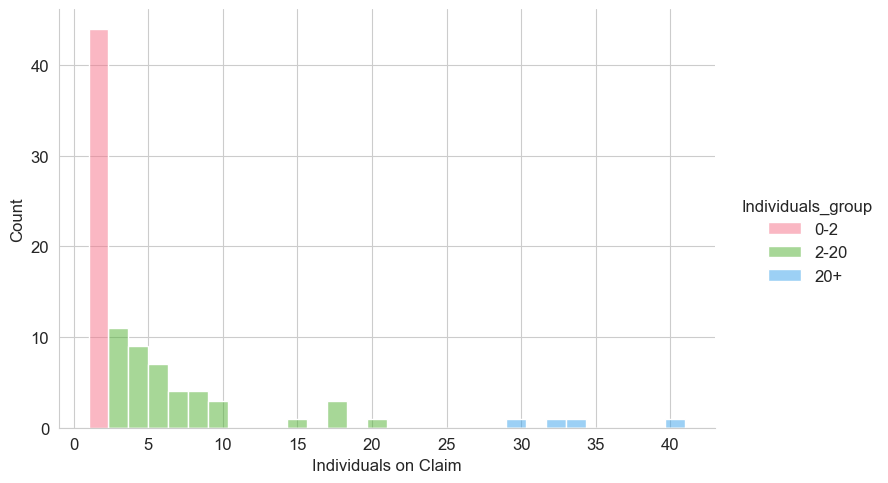

In [19]:
g = sns.displot(data=df, x='Individuals on Claim', bins=30, height=5, aspect=1.5, hue='Individuals_group')

### 3.2. Answering 1st question : How does the number of claims differ across locations?

In [20]:
claims_location = df.groupby('Location')['Claim ID'].count().sort_values(ascending=False)
print(claims_location)

Location
SAO LUIS     30
RECIFE       25
FORTALEZA    22
NATAL        21
Name: Claim ID, dtype: int64


<AxesSubplot:title={'center':'Number of claims across locations'}, xlabel='Location'>

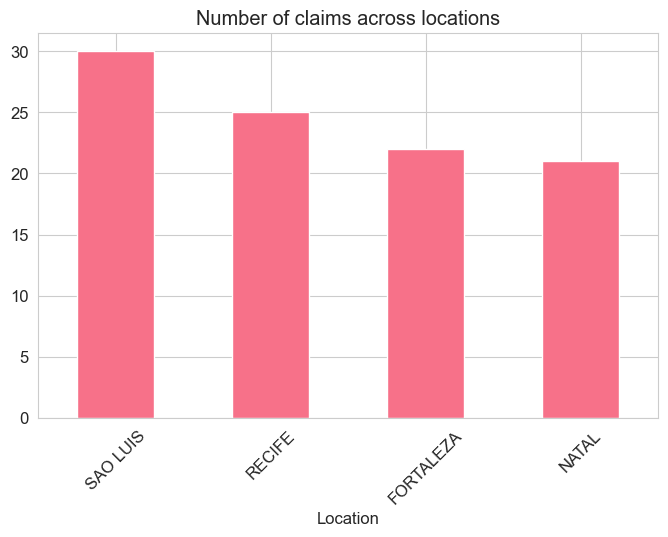

In [21]:
claims_location.plot(kind='bar', title='Number of claims across locations', figsize=(8,5), rot=45)

The number of claims across locations is quite homogeneous, despite slightly larger figures in Sao Luis and Recife.<br>
Let's use previous grouping sets in order to visualize potential differences between Location.

In [22]:
claims_location_amount = df.groupby(['Location','Amount_group'])['Claim ID'].count()
claims_location_indiv = df.groupby(['Location','Individuals_group'])['Claim ID'].count()
display(claims_location_amount, claims_location_indiv)

Location   Amount_group
FORTALEZA  small            1
           medium          15
           big              6
NATAL      small            1
           medium          13
           big              7
RECIFE     small            3
           medium          14
           big              8
SAO LUIS   small            3
           medium          17
           big             10
Name: Claim ID, dtype: int64

Location   Individuals_group
FORTALEZA  0-2                  11
           2-20                 10
           20+                   0
NATAL      0-2                  10
           2-20                  8
           20+                   2
RECIFE     0-2                   9
           2-20                 12
           20+                   1
SAO LUIS   0-2                  14
           2-20                 13
           20+                   1
Name: Claim ID, dtype: int64

In [23]:
# pivoting grouped dataframes in order to build stacked bar graphs
df_pivot_amount = claims_location_amount.reset_index('Amount_group').pivot(columns='Amount_group')
df_pivot_indiv = claims_location_indiv.reset_index('Individuals_group').pivot(columns='Individuals_group')
display(df_pivot_amount, df_pivot_indiv)

Claim ID           
Amount_group    small medium big
Location                        
FORTALEZA           1     15   6
NATAL               1     13   7
RECIFE              3     14   8
SAO LUIS            3     17  10

Claim ID         
Individuals_group      0-2 2-20 20+
Location                           
FORTALEZA               11   10   0
NATAL                   10    8   2
RECIFE                   9   12   1
SAO LUIS                14   13   1

Text(0.5, 1.05, 'Number of claims accross locations and groups')

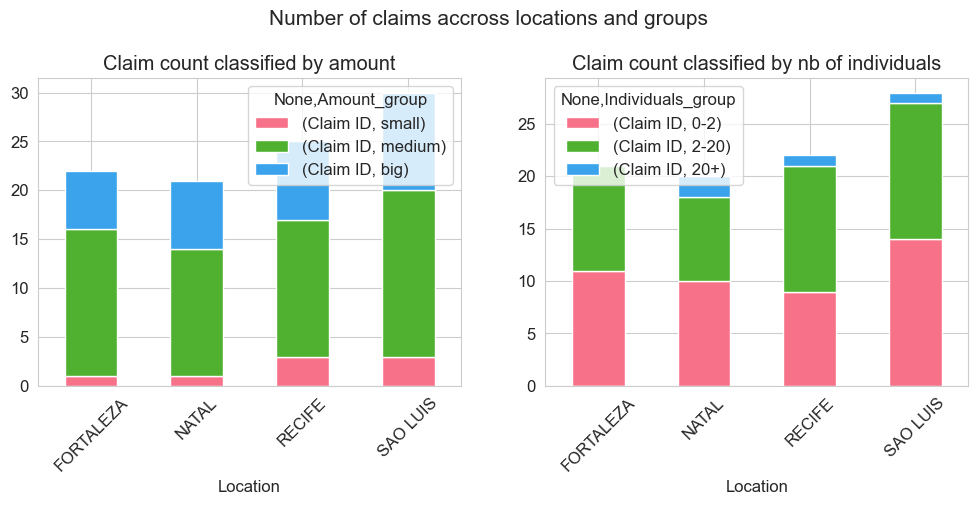

In [24]:
# Let's now create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df_pivot_amount.plot(kind='bar', stacked=True, ax=ax1, title='Claim count classified by amount', rot=45)
df_pivot_indiv.plot(kind='bar', stacked=True, ax=ax2, title='Claim count classified by nb of individuals', rot=45)
fig.suptitle('Number of claims accross locations and groups', y=1.05, fontsize=15)

Here what we can see through those 2-axes independent analysis :
<li>Claim amounts are spread accros all 4 locations
<li>Sao Luis has notably more claims involving SMALL individual groups, related to pretty small or medium-size claim amounts
<li>Fortaleza doesn't receive claims involving more that 20 individuals</li>

### 3.3. Answering 2nd question : What is the distribution of time to close claims?

Text(0.5, 0.98, 'Distribution of time to close claims')

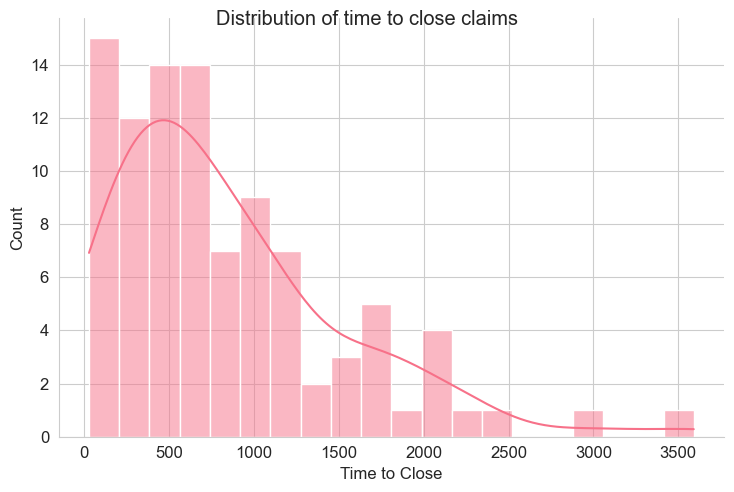

In [25]:
g = sns.displot(data=df, x='Time to Close', kind='hist', bins=20, height=5, aspect=1.5, kde=True)
g.fig.suptitle('Distribution of time to close claims')

In [26]:
time_stats = df['Time to Close'].describe()
print(round(time_stats,2))

count      97.00
mean      841.52
std       684.36
min        29.00
25%       349.00
50%       639.00
75%      1143.00
max      3591.00
Name: Time to Close, dtype: float64


Distribution of time to close claims is right skewed :
<li>there are 50% of claims that are closed within 639 days, equivalent to 1,7 years
<li>some claims can take a very long time to close : still 25% of claims are not closed after 3 years

### 3.4. Answering 3rd question : How does the average time to close claims differ by location?

In [27]:
time_stats_det = df.groupby('Location')['Time to Close'].agg(['mean','median'])
round(time_stats_det,2)

,mean,median
Location,,
FORTALEZA,775.50,611.0
NATAL,581.14,477.0
RECIFE,860.68,875.0
SAO LUIS,1063.62,1051.0


Text(0.5, 0.98, 'Average time to close claims by location')

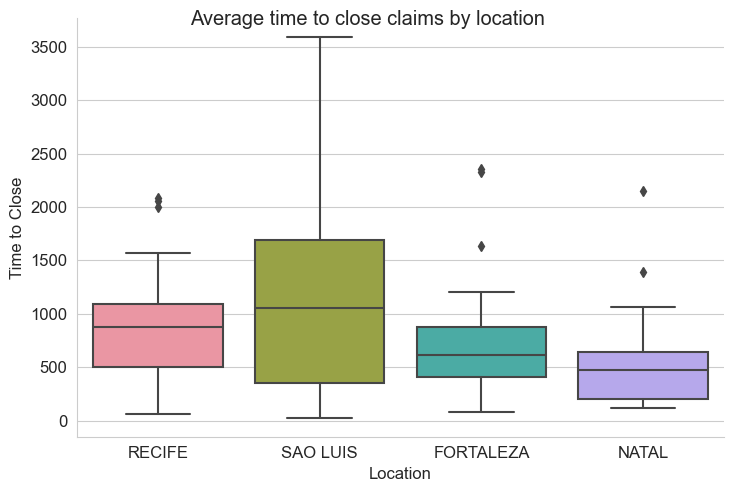

In [28]:
g = sns.catplot(data=df, x='Location', y='Time to Close', kind='box', height=5, aspect=1.5)
g.fig.suptitle('Average time to close claims by location')

On average (median level), Claims in Sao Luis are about twice as long to close than claims in Fortaleza or Natal. Recife is intermediate.
Sao Luis seems to have a wide range of leadtimes to close the claims. No visible outliers seems to indicate that diversity of claims is the norm in Sao Luis.
Let's take a deeper look on Sao Luis claims.

Text(0.5, 1.05, 'Average time to close claims by location')

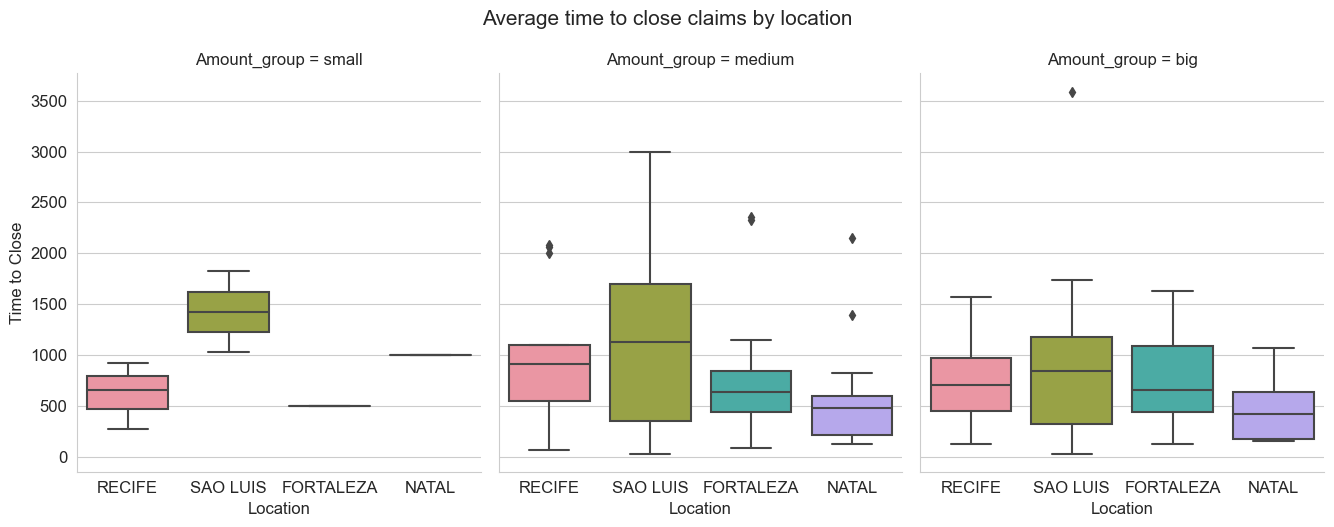

In [35]:
g = sns.catplot(data=df, x='Location', y='Time to Close', kind='box', height=5, aspect=0.9, col='Amount_group')
g.fig.suptitle('Average time to close claims by location', y=1.05, fontsize=15)

Those graphs show that claims of small amounts seem to be of weaker concern for Sao Luis location, as Time to Close is much longer in this group.<br>
Natal, which receives the highest rate of big claims seems to have processed claim negociations (and close) in the fastest way.

## 4. Conclusion

Answering the legal team that would like to see if there are some differences in the time it takes to close claims across the locations, the answer is Yes.

The analysis led us to conclude that Sao Luis is of particular concern :
<li>Small to medium-size claims (both in amounts and in number of individuals concerns) are predominent in Sao Luis
<li>It seems to be a time-consuming bottleneck that slows the entire process in this location</li>

On the other hand, Natal workflow focuses on big affairs, with a resolving process which seems to be quite efficient.
Recife and Fortaleza have in-between positions.

A suggestion could be to balance this workload with legal specialists acting either for the flow business (small claims) or for big claims. Thus, efficiency would level up by creating working habits for each type of legal business.